In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader,TensorDataset

import scipy.stats as stat
from scipy.special import rel_entr

from sklearn.model_selection import train_test_split
import time

#MNIST dataset

In [25]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv','rb'),delimiter = ',')
data.shape

(20000, 785)

In [26]:
labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


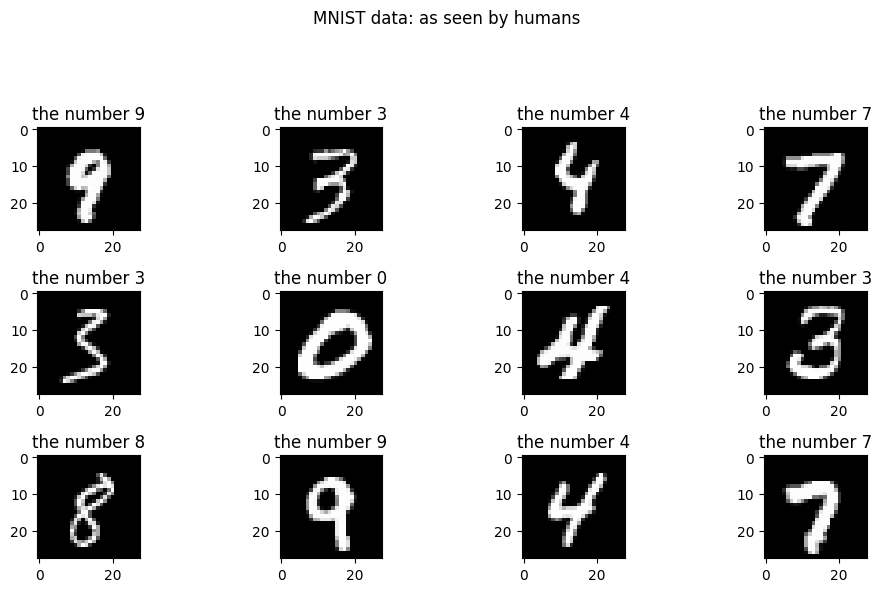

In [34]:
fig, axs = plt.subplots(3,4,figsize = (10,6))

for ax in axs.flatten():
  randimg = np.random.randint(0,high = data.shape[0])

  img = np.reshape(data[randimg,:],(28,28))
  ax.imshow(img,cmap = "gray")

  ax.set_title("the number %i" %labels[randimg])

plt.suptitle("MNIST data: as seen by humans",fontsize = 12)
plt.tight_layout(rect = [0,0,1,.9])

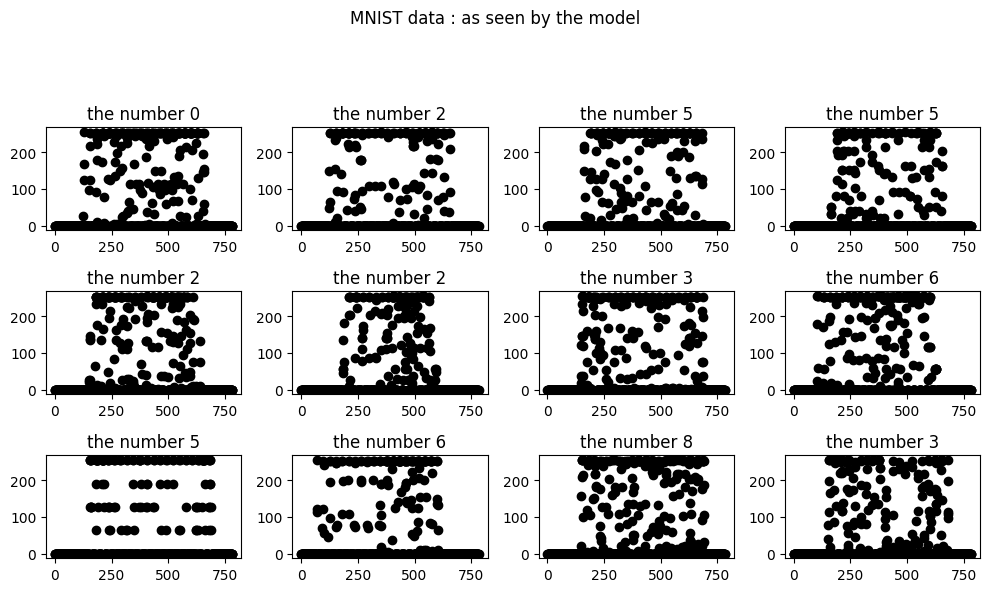

In [35]:
fig, axs = plt.subplots(3,4,figsize = (10,6))

for ax in axs.flatten():
  randimg = np.random.randint(0,high = data.shape[0])

  ax.plot(data[randimg,:],'ko')

  ax.set_title("the number %i" %labels[randimg])

plt.suptitle("MNIST data : as seen by the model",fontsize = 12)
plt.tight_layout(rect = [0,0,1,.9])

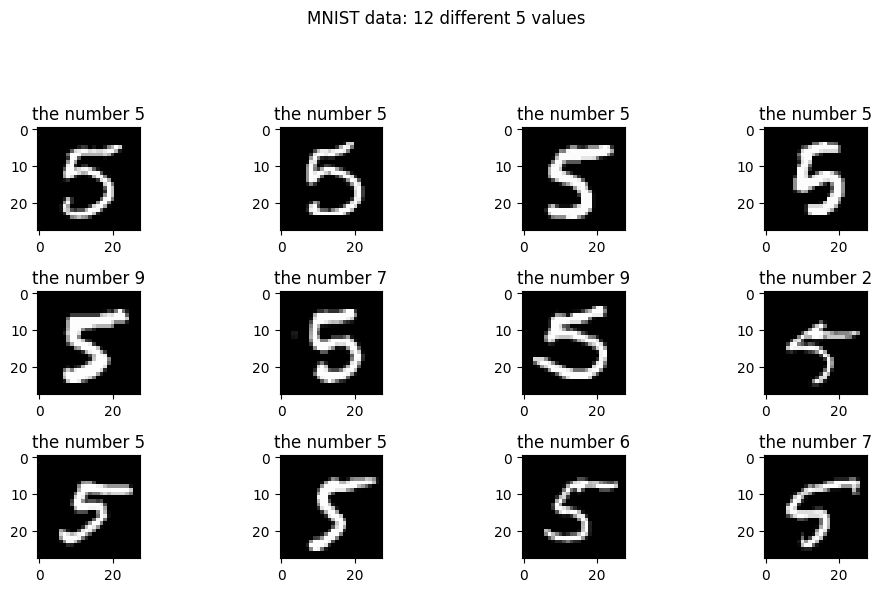

In [42]:
plot_data = data[labels==5][0:12,:]

fig, axs = plt.subplots(3,4,figsize = (10,6))

for i,ax in enumerate(axs.flatten()):
  randimg = np.random.randint(0,high = 12)

  img = np.reshape(plot_data[i,:],(28,28))
  ax.imshow(img,cmap = "gray")

  ax.set_title("the number %i" %labels[randimg])

plt.suptitle("MNIST data: 12 different 5 values",fontsize = 12)
plt.tight_layout(rect = [0,0,1,.9])

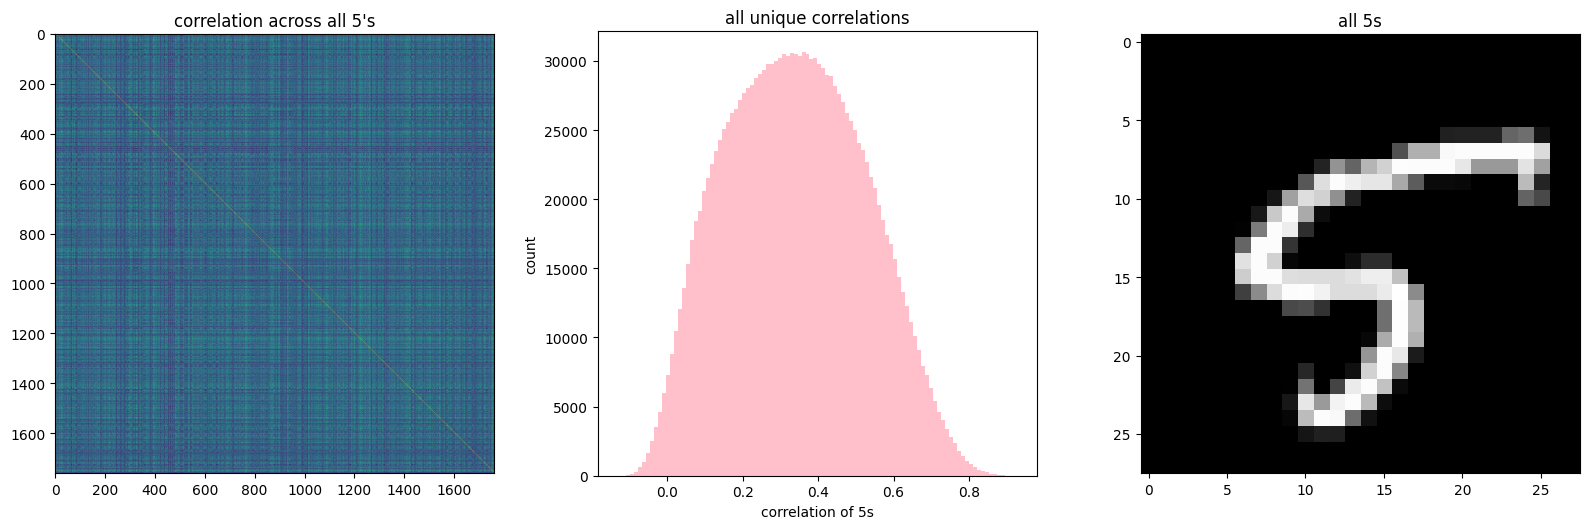

In [49]:
the5s = data[labels==5][0:12,:]
the5s = data[labels==5]

c = np.corrcoef(the5s)

fig,ax = plt.subplots(1,3,figsize = (16,6))
ax[0].imshow(c,vmin=0,vmax = 1)
ax[0].set_title("correlation across all 5's")

uniquecs = np.triu(c,k=1).flatten()
ax[1].hist(uniquecs[uniquecs!=0],bins =100,color = 'pink')
ax[1].set_title("all unique correlations")
ax[1].set_xlabel("correlation of 5s")
ax[1].set_ylabel("count")

ave5s = np.reshape(np.mean(the5s,axis = 0),(28,28))
ax[2].imshow(img,cmap = "gray")
ax[2].set_title("all 5s")
plt.tight_layout(rect = [0,0,1,.9])

#FFN to model MNIST data

In [64]:
data = np.loadtxt(open('/content/sample_data/mnist_train_small.csv','rb'),delimiter = ',')
print(data.shape)

labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)

(20000, 785)
(20000,)
(20000, 784)


In [68]:
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, train_size=0.8)
print(data_train.shape)
print(data_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(16000, 784)
(4000, 784)
(16000,)
(4000,)


In [79]:
data_train_tensor = torch.tensor(data_train).float()
data_test_tensor = torch.tensor(data_test).float()
print(data_train_tensor.shape)

labels_train_tensor = torch.tensor(labels_train).long()
labels_test_tensor = torch.tensor(labels_test).long()
print(labels_train_tensor.shape)

torch.Size([16000, 784])
torch.Size([16000])


In [129]:
mnist_model_1 = nn.Sequential(
    nn.Linear(784,64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64,10)
)

lossfun = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(mnist_model_1.parameters(),lr = .01)

print(mnist_model_1)
mnist_model_1(data_train_tensor) #test

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)


tensor([[  0.9052,  -1.7660,  -8.5434,  ..., -12.2628,  -3.2549, -10.2450],
        [  4.0554,   7.1100,   0.4138,  ...,   0.9105,   0.5123,   2.2808],
        [ -1.1126,  17.5534,  -1.8158,  ..., -15.3422,   8.9178,  -8.0048],
        ...,
        [ -5.3558,   0.2018, -11.1137,  ..., -11.1120,  -0.1057,  -8.0976],
        [  2.3607,   8.8216,  -0.8171,  ...,  -2.0882,   3.1798,  -1.9655],
        [ -1.5035,   1.4533,  -2.0245,  ...,  -5.2456,   0.3292,  -5.5596]],
       grad_fn=<AddmmBackward0>)

In [130]:
def training_1 (data_train_tensor,data_test_tensor,\
                labels_train_tensor,labels_test_tensor,\
                model,lossfun,optimizer,numepochs):

  lossTraining = np.zeros(numepochs)
  trainAcc = np.zeros(numepochs)
  testAcc = np.zeros(numepochs)

  for i in range(numepochs):
    yhat = model(data_train_tensor)
    loss = lossfun(yhat,labels_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lossTraining[i] = loss

    trainAcc[i] = torch.mean((torch.argmax(yhat,axis = 1)==labels_train_tensor).float())

    model.eval()
    with torch.no_grad():
      yhat = model(data_test_tensor)
      testAcc[i] = torch.mean((torch.argmax(yhat,axis = 1)==labels_test_tensor).float())

    model.train()


  return trainAcc,testAcc,lossTraining

test accuracy : 0.8822500109672546


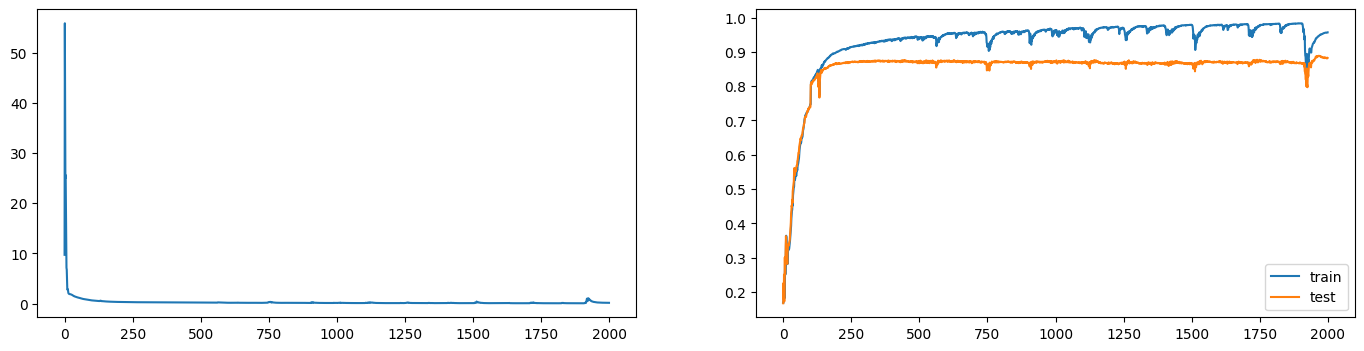

In [131]:
numepochs = 2000
trainAcc,testAcc,lossTraining = training_1 (data_train_tensor,data_test_tensor,\
                                    labels_train_tensor,labels_test_tensor, mnist_model_1,lossfun,optimizer,numepochs)

fig,ax = plt.subplots(1,2, figsize = (17,4))
ax[0].plot(lossTraining)

ax[1].plot(trainAcc)
ax[1].plot(testAcc)
ax[1].legend(["train","test"])

print("test accuracy :", testAcc[-1])

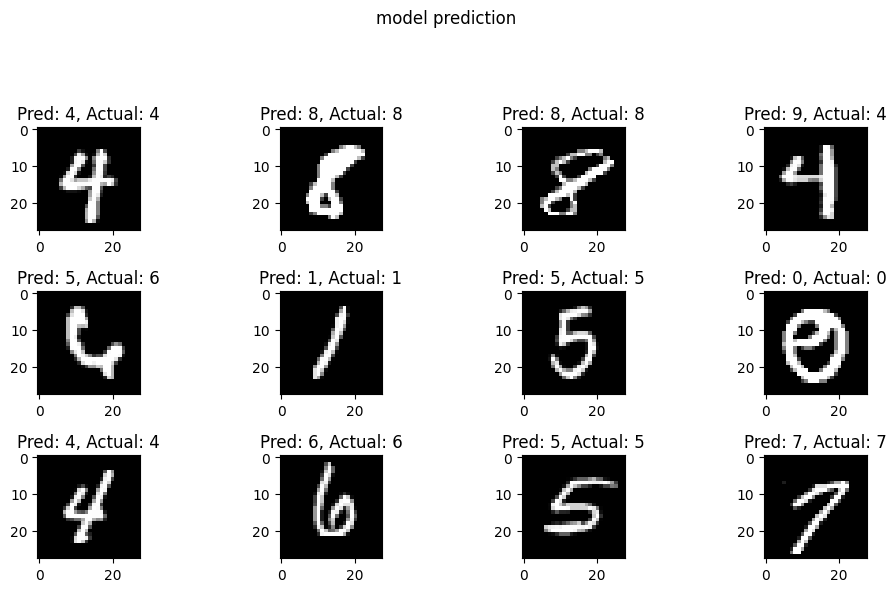

In [132]:
pred = torch.argmax(mnist_model_1(data_test_tensor).detach(),axis = 1)

fig, axs = plt.subplots(3,4,figsize = (10,6))

for i,ax in enumerate(axs.flatten()):
  randimg = np.random.randint(0,high = 12)

  img = np.reshape(data_test_tensor[i,:],(28,28))
  ax.imshow(img,cmap = "gray")

  ax.set_title("Pred: %d, Actual: %d" % (pred[i], labels_test_tensor[i]))

plt.suptitle("model prediction",fontsize = 12)
plt.tight_layout(rect = [0,0,1,.9])